In [1]:
import numpy as np
import pandas as pd
import nltk
import gensim
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

In [7]:
data = pd.read_csv('/Users/mjy/Desktop/review10000.csv')

In [8]:
data.head(10)

,business_id,user_id,text
0,ujmEBvifdJM6h6RLv4wQIg,hG7b0MtEbXx5QzbzE6C_VA,Total bill for this horrible service? Over $8G...
1,NZnhc2sEQy3RmzKTZnqtwQ,yXQM5uF2jS6es16SJzNHfg,I *adore* Travis at the Hard Rock's new Kelly ...
2,WTqjgwHlXbSFevF32_DJVw,n6-Gk65cPZL6Uz8qRm3NYw,I have to say that this office really has it t...
3,ikCg8xy5JIg_NGPx-MSIDA,dacAIZ6fTM6mqwW5uxkskg,Went in for a lunch. Steak sandwich was delici...
4,b1b1eb3uo-w561D0ZfCEiQ,ssoyf2_x0EQMed6fgHeMyQ,Today was my second out of three sessions I ha...
5,eU_713ec6fTGNO4BegRaww,w31MKYsNFMrjhWxxAb5wIw,I'll be the first to admit that I was not exci...
6,3fw2X5bZYeW9xCz_zGhOHg,jlu4CztcSxrKx56ba1a5AQ,Tracy dessert had a big name in Hong Kong and ...
7,zvO-PJCpNk4fgAVUnExYAA,d6xvYpyzcfbF_AZ8vMB7QA,This place has gone down hill. Clearly they h...
8,b2jN2mm9Wf3RcrZCgfo1cg,sG_h0dIzTKWa3Q6fmb4u-g,I was really looking forward to visiting after...
9,oxwGyA17NL6c5t1Etg5WgQ,nMeCE5-xsdleyxYuNZ_7rA,It's a giant Best Buy with 66 registers. I do...


In [9]:
review_stopword = gensim.parsing.preprocessing.STOPWORDS
add_stopword = ['food','place','lot']
review_stopword = review_stopword.union(set(add_stopword))

In [10]:
from nltk import pos_tag
is_noun = lambda pos: pos[:2] == 'NN'

# lemmatizing
def lemmatize(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    return wordnet_lemmatizer.lemmatize(text)

# Tokenize and lemmatize
def preprocess(text):
    tokens = []
    for word in text.split():
        if word.isalpha() == True:
            tokens.append(word.lower())
    #remove stopwords
    tokens = [w for w in tokens if not w in review_stopword]
    tokens = [w for w in tokens if not len(w)<3]
    #keep only noun
    tokens = [w for (w, pos) in pos_tag(tokens) if is_noun(pos)]
    #remove duplicate
    tokens = list(dict.fromkeys(tokens))
    tokens = [lemmatize(w) for w in tokens] 
            
    return tokens

data['text'] = data['text'].apply(lambda x: preprocess(x))

In [11]:
data.head(3)

,business_id,user_id,text
0,ujmEBvifdJM6h6RLv4wQIg,hG7b0MtEbXx5QzbzE6C_VA,"[crook, charge, pill, cent, hospital, er]"
1,NZnhc2sEQy3RmzKTZnqtwQ,yXQM5uF2jS6es16SJzNHfg,"[fan, blowout, stranger, chain, flawless, gree..."
2,WTqjgwHlXbSFevF32_DJVw,n6-Gk65cPZL6Uz8qRm3NYw,"[office, assistant, procedure, jewel, bailey, ..."


In [12]:
data.text[:10]

0            [crook, charge, pill, cent, hospital, er]
1    [fan, blowout, stranger, chain, flawless, gree...
2    [office, assistant, procedure, jewel, bailey, ...
3    [steak, sandwich, caesar, salad, perfect, drin...
4    [today, session, session, tell, meredith, enjo...
5    [admit, group, friend, dinner, menu, ordering,...
6    [tracy, dessert, hong, kong, year, selection, ...
7    [staff, quality, review, year, service, worth,...
8    [rusulka, vanilla, sweet, notch, miss, beer, c...
9                                   [giant, buy, deal]
Name: text, dtype: object

In [13]:
reviews = data['text']
dictionary = gensim.corpora.Dictionary(reviews) # Associate words to a numeric ID
bow_corpus = [dictionary.doc2bow(doc) for doc in reviews] # Transform the collection of texts to a numerical form

In [15]:
reviews[:10]

0            [crook, charge, pill, cent, hospital, er]
1    [fan, blowout, stranger, chain, flawless, gree...
2    [office, assistant, procedure, jewel, bailey, ...
3    [steak, sandwich, caesar, salad, perfect, drin...
4    [today, session, session, tell, meredith, enjo...
5    [admit, group, friend, dinner, menu, ordering,...
6    [tracy, dessert, hong, kong, year, selection, ...
7    [staff, quality, review, year, service, worth,...
8    [rusulka, vanilla, sweet, notch, miss, beer, c...
9                                   [giant, buy, deal]
Name: text, dtype: object

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
# Warning: This cell takes a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=bow_corpus, texts=reviews, start=10, limit=20, step=1)

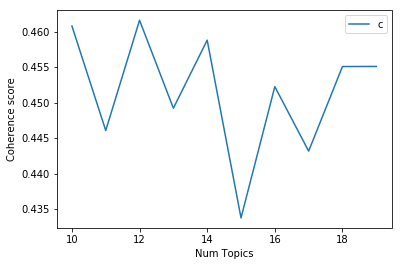

In [18]:
# Show graph
limit=20; start=10; step=1;
x = range(start, limit, step)

plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 5, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

In [20]:
for idx in range(5):
    # Print the first 16 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))

Topic #0: 0.021*"time" + 0.013*"order" + 0.010*"way" + 0.009*"staff" + 0.007*"restaurant" + 0.007*"burger" + 0.007*"service" + 0.007*"taste" + 0.007*"fry" + 0.006*"thing"
Topic #1: 0.017*"service" + 0.012*"time" + 0.009*"drink" + 0.008*"people" + 0.008*"night" + 0.008*"bar" + 0.007*"thing" + 0.007*"restaurant" + 0.007*"beer" + 0.006*"price"
Topic #2: 0.008*"service" + 0.007*"order" + 0.007*"way" + 0.007*"area" + 0.006*"super" + 0.006*"chicken" + 0.006*"price" + 0.005*"staff" + 0.005*"ice" + 0.004*"wing"
Topic #3: 0.025*"time" + 0.020*"service" + 0.017*"customer" + 0.010*"people" + 0.009*"staff" + 0.009*"day" + 0.009*"thing" + 0.008*"price" + 0.008*"hour" + 0.007*"minute"
Topic #4: 0.020*"service" + 0.016*"time" + 0.012*"restaurant" + 0.011*"love" + 0.009*"staff" + 0.009*"chicken" + 0.008*"price" + 0.007*"salad" + 0.007*"order" + 0.007*"sandwich"


In [21]:
# Displaying topics in a table (a better visualisation)
word_dict = {};
for i in range(5):
    words = lda_model.show_topic(i, topn = 50)
    word_dict['Topic # ' + '{:02d}'.format(i)] = [i[0] for i in words]
word_dict = pd.DataFrame(word_dict)

In [22]:
word_dict.to_csv('/Users/mjy/Desktop/clean_data.csv')
#word_dict

In [23]:
topic_word = {}
for i in range(1,6):
    word_list = []
    for w in word_dict.iloc[:,i-1]:
        word_list.append(w)
    topic_word[i] = word_list

In [24]:
new_list = []
for k, v in topic_word.items():
    new_list.append([k,v])
    
new_list = pd.DataFrame(data = new_list)


In [25]:
new_list.to_csv('/Users/mjy/Desktop/topic.csv')

In [26]:
# topic_5 = pd.DataFrame(data = topic_word, columns = ['index','key_word'])

In [27]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        ##
        ##
        ##
        # Add the row code here
        ##
        ##
        ##
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
#                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [28]:
# Warning: This cell takes quite some time to run
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=reviews)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'reviewTxt']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,reviewTxt
0,0,3.0,0.8850,"[crook, charge, pill, cent, hospital, er]"
1,1,3.0,0.5390,"[fan, blowout, stranger, chain, flawless, gree..."
2,2,3.0,0.9267,"[office, assistant, procedure, jewel, bailey, ..."
3,3,1.0,0.5701,"[steak, sandwich, caesar, salad, perfect, drin..."
4,4,3.0,0.5630,"[today, session, session, tell, meredith, enjo..."
5,5,1.0,0.8618,"[admit, group, friend, dinner, menu, ordering,..."
6,6,1.0,0.6700,"[tracy, dessert, hong, kong, year, selection, ..."
7,7,3.0,0.9095,"[staff, quality, review, year, service, worth,..."
8,8,3.0,0.4299,"[rusulka, vanilla, sweet, notch, miss, beer, c..."
9,9,0.0,0.7943,"[giant, buy, deal]"


In [29]:
df_dominant_topic.to_csv('/Users/mjy/Desktop/dominant_topic.csv')

In [30]:
word_dict

,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04
0,time,service,service,time,service
1,order,time,order,service,time
2,way,drink,way,customer,restaurant
3,staff,people,area,people,love
4,restaurant,night,super,staff,staff
5,burger,bar,chicken,day,chicken
6,service,thing,price,thing,price
7,taste,restaurant,staff,price,salad
8,fry,beer,ice,hour,order
9,thing,price,wing,minute,sandwich
